# Information retrieval for movies recommendation

Database which the project it's based on:   
[HBO Max](https://www.kaggle.com/datasets/dgoenrique/hbo-max-movies-and-tv-shows)  

<div></div> 

In [1]:
import numpy as np 
import pandas as pd

<div></div> 

## Files import

No secret here, mate. The databases came with a CSV extension. So, there're no major problems here, only use pandas for the import and it's all fine.

<div></div> 

In [7]:
movies = pd.read_csv('../data/titles.csv')
movies.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,tm77588,Casablanca,MOVIE,"In Casablanca, Morocco in December 1941, a cyn...",1943,PG,102,"['drama', 'romance', 'war']",['US'],NaN,tt0034583,8.5,577842.0,22.005,8.167
1,tm155702,The Wizard of Oz,MOVIE,Young Dorothy finds herself in a magical world...,1939,G,102,"['fantasy', 'family']",['US'],NaN,tt0032138,8.1,406105.0,56.631,7.583


## Data Explotarion

In [12]:
from plotnine import *
from plotnine.data import diamonds

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 299 rows containing non-finite values.
C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


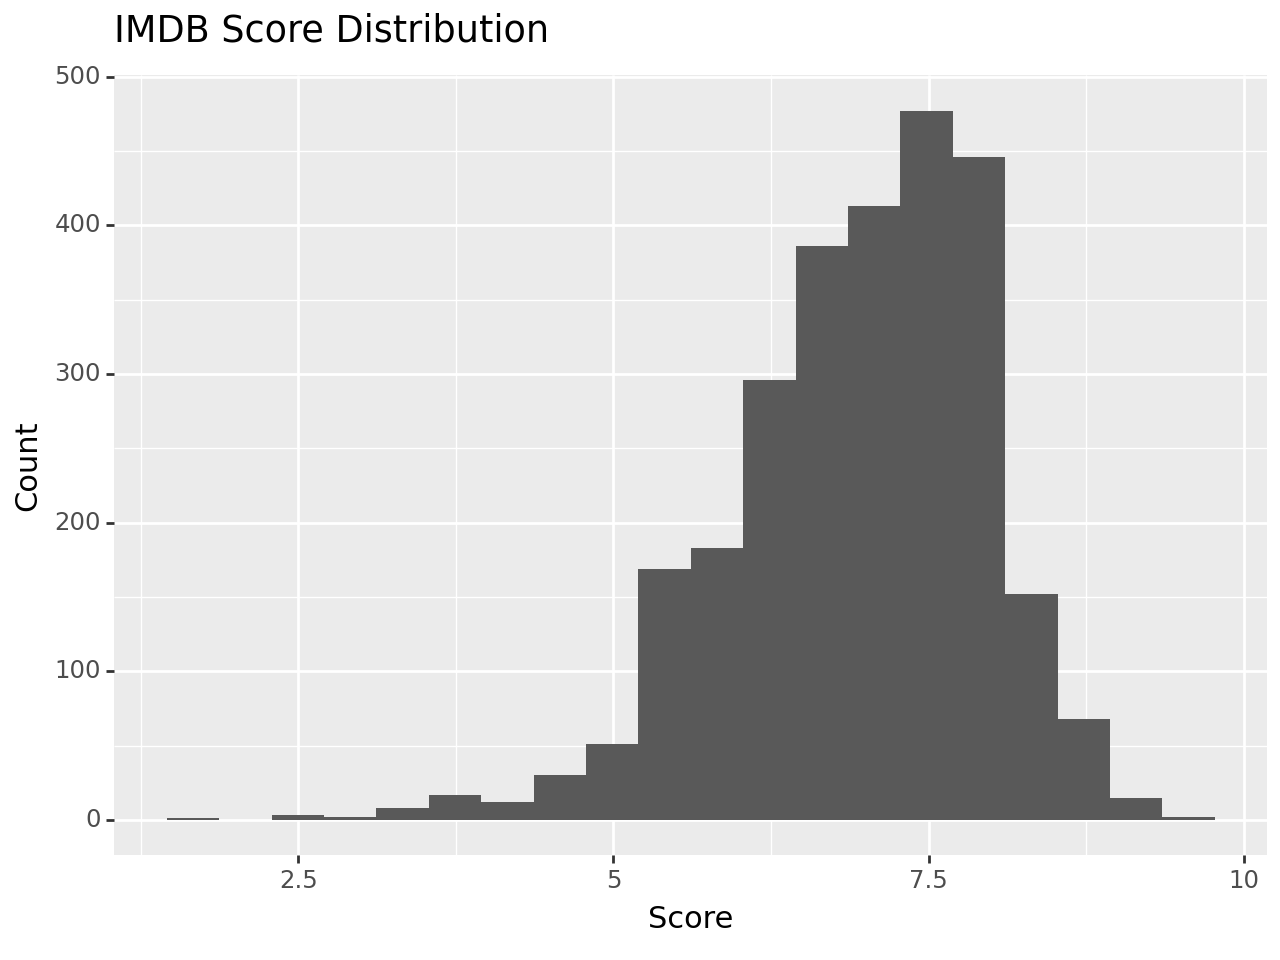

<Figure Size: (640 x 480)>

In [44]:
(
    ggplot(movies, aes(x='imdb_score'))
    + geom_histogram(bins=20) 
    + labs(title='IMDB Score Distribution', x = 'Score', y = 'Count') 
    + scale_fill_gradient(low='#D32F2F', high='#536DFE')
)

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 172 rows containing non-finite values.


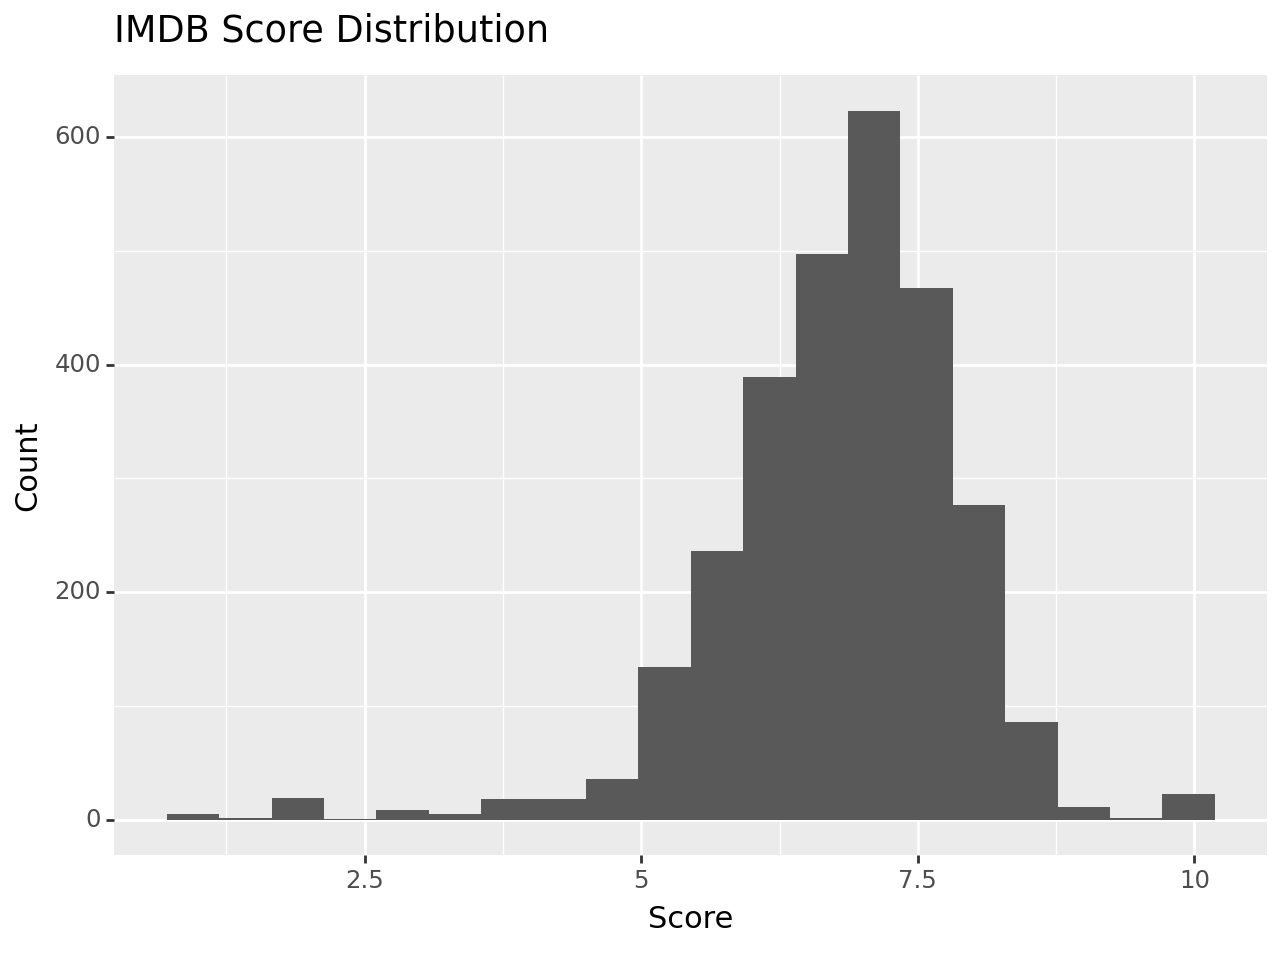

<Figure Size: (640 x 480)>

In [53]:
(
    ggplot(movies, aes(x='tmdb_score'))
    + geom_histogram(bins=20) 
    + labs(title='IMDB Score Distribution', x = 'Score', y = 'Count') 
    # + scale_fill_gradient(low='#D32F2F', high='#536DFE')
    # + scale_fill_manual(['red', 'green'])
)

<div></div> 

## Pré-Processamento de Texto

Para minimizar possíveis gargalos de processamento e identificação dos termos relevantes, é realizada a remoção de ruídos utilizando regex. Em seguida, é aplicada a tokenização, que consiste na transformação do texto em uma lista de palavras, a fim de possibilitar a aplicação das técnicas de TF-IDF em um modelo vetorial.

Além disso, foram feitas alguns processsos adicionais para possibilitar o processamento sem erros

<div></div> 


### Tratamento dos gêneros

In [4]:
# Preenchimento de NAN para variaveis de gêrenos que contém listas como elementos
base['genres'] = base['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i for i in x] if isinstance(x, list) else [])

### Remoção de palavras e transformação de minúsculos

In [5]:
# (\[a-z]): para encontrar todos os caracteres que começam com uma barra invertida () seguida por uma letra minúscula (a-z);
# ([^\w\]): para encontrar todos os caracteres que não são letras, números ou barras invertidas ();
# (\S+\d\S+): para encontrar todos os trechos de texto que contêm um ou mais caracteres não brancos (\S), 
# seguidos por um dígito (\d), seguidos por mais um ou mais caracteres não brancos (\S).
base['post'] = base['description'].replace(r'(\\[a-z])|([^\w\\])|(\S+\d\S+)', ' ', regex=True)

# Aplicando as funções str.lower() e str.strip() simultaneamente
base['post'] = base['post'].apply(lambda x: x.lower().strip() if isinstance(x, str) else x)


<div></div> 

### Tokenização e Lemmatizer

**Tokenização:** A tokenização de texto é o processo de dividir um texto em unidades menores, chamadas de tokens. Esses tokens podem ser palavras individuais, caracteres, frases ou até mesmo partes específicas de um texto, dependendo do contexto e das necessidades do processamento de linguagem natural. 

**Lemmatize:** A lematização de texto é um processo linguístico que visa reduzir as palavras em sua forma base ou forma lematizada. O objetivo é transformar palavras flexionadas em sua forma canônica, chamada de "lema" ou "base". Por exemplo, a lematização transforma palavras como "correndo" em "correr", "carros" em "carro" e assim por diante.<div></div> 

### Tokenização e Lemmatizer

<div></div>

In [6]:
from ir.preprocessing import lemmatize_word

base['post'] = base['post'].apply(lambda x: ' '.join([lemmatize_word(word.lower()) for word in x.split()]))


### Identificação das query / docs

Foi feita uma separação do index das query, para pode fazer uma localização do na base origina após o TF-IDF, dado que o TF-IDF reseta os index dos termos por documento

In [7]:
np.random.seed(42)
rand = np.random.random(base.shape[0])

d_index = rand <  0.7
q_index = rand >= 0.7

## Processamento dos dados

Aplicação das técnicas estatísticas no conjunto de palavras por documento

### TF IDF

TF-IDF (Term Frequency-Inverse Document Frequency) é uma medida estatística usada para avaliar a importância de um termo em um documento em relação a uma coleção de documentos. É amplamente utilizado em processamento de linguagem natural e recuperação de informações.

O TF-IDF é calculado levando em consideração dois fatores principais:

Frequência do termo (TF - Term Frequency): Mede a frequência com que um termo específico aparece em um documento. Quanto mais vezes um termo aparece, maior é sua relevância no documento.

Frequência inversa do documento (IDF - Inverse Document Frequency): Mede a raridade de um termo em relação a uma coleção de documentos. Quanto menos frequente um termo é em outros documentos da coleção, maior é o seu valor IDF e maior será seu peso para distinguir a importância desse termo no documento atual.

O TF-IDF é calculado multiplicando-se o TF pelo IDF para cada termo em um documento. Dessa forma, termos frequentes no documento e raros na coleção terão um valor TF-IDF mais alto, indicando sua relevância para o documento em questão.

Essa medida é amplamente utilizada em tarefas como recuperação de informações, classificação de texto, sumarização automática e agrupamento de documentos.

In [8]:
from ir.tf_idf import tfidf

weights = tfidf(base, 'post').T

## Ranqueamento

O ranqueamento de documentos utilizando o TF-IDF (Term Frequency-Inverse Document Frequency) é um método utilizado para ordenar documentos em uma coleção com base na relevância em relação a uma consulta de busca.

Nesse método, cada documento é representado por um vetor numérico, no qual cada dimensão corresponde a um termo presente na coleção de documentos. O valor de cada dimensão é calculado utilizando a fórmula do TF-IDF, que leva em consideração a frequência do termo no documento e a raridade do termo na coleção.

In [9]:
from sklearn.metrics.pairwise import linear_kernel

q_index = base[q_index].index
d_index = base[d_index].index

**Importante**

A celula abaixo trás o mesmo resultado da célula seguinte, porém, com tempo de processamente extremamente maior e maior consumo de RAM. 
Recomendo que só seja utilizada, caso deseje compreender o funcionamento do algoritmo e caso tenha uma boa máquina para rodar o processo

In [10]:
# import numpy as np
# from numba import njit, prange
# import sys

# @njit(parallel=True)
# def calcular_similaridade_cosseno(vetor1, vetor2):
#     # Verifica se os vetores têm o mesmo tamanho
#     if len(vetor1) != len(vetor2):
#         return 0
    
#     # Calcula o produto interno entre os vetores
#     produto_interno = np.dot(vetor1, vetor2)
    
#     # Calcula a norma dos vetores
#     norma_vetor1 = np.linalg.norm(vetor1)
#     norma_vetor2 = np.linalg.norm(vetor2)
    
#     # Calcula a similaridade do cosseno
#     if (norma_vetor1 * norma_vetor2) != 0: 
#         similaridade_cosseno = produto_interno / (norma_vetor1 * norma_vetor2)
#     else: 
#         return 0
    
#     return similaridade_cosseno

# rank_geral = {}

# for q in q_index: 
#     rank = []
#     for d in d_index: 
#         rank.append(calcular_similaridade_cosseno(weights.iloc[q].to_numpy(), weights.iloc[d].to_numpy()))
#         print(f"\r query: {q} - doc: {d}", end="")
#         sys.stdout.flush()
        
#     rank_geral[q] = rank


In [11]:
rank_geral = linear_kernel(weights.iloc[d_index], weights.iloc[q_index])
rank_geral = pd.DataFrame(rank_geral, index=d_index, columns=q_index)
rank_geral

,1,2,7,9,11,12,25,33,34,35,...,3067,3070,3075,3076,3079,3080,3081,3084,3091,3093
0,67.368755,0.124803,0.205029,0.238001,0.204541,0.046762,0.441678,13.829039,6.719963,0.962032,...,0.069073,0.505155,0.144191,0.124803,0.060839,0.475713,0.290585,0.185641,0.254428,0.285274
3,0.282496,13.334045,0.343334,14.437079,0.475440,0.046762,0.394488,0.400331,0.404862,14.536195,...,0.069073,0.601933,0.032989,0.000000,0.386254,0.447286,0.497031,0.461363,0.032989,0.343334
4,13.385497,0.162372,0.205030,3.125362,0.286482,0.046762,6.935597,13.952442,0.409103,0.670516,...,0.069074,0.629949,2.518161,0.162372,0.116679,0.089682,2.508806,6.470416,2.519247,0.352836
5,0.282496,20.525454,0.329257,49.233188,0.593763,4.704261,10.166065,0.632075,0.473186,15.323314,...,10.564372,48.295855,2.331051,38.901016,0.329257,0.832429,7.396474,5.345418,2.476327,0.621255
6,0.217132,8.682580,21.944596,15.177606,18.879542,0.061065,22.114967,13.841739,33.477328,2.140575,...,0.090200,57.483639,0.000000,4.605783,25.399635,30.052399,5.508488,0.361942,18.499217,7.888895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,0.000000,11.899035,0.046763,0.223924,0.187207,0.035942,0.398453,13.650255,0.160698,0.371556,...,5.021244,15.244205,0.185743,0.124803,0.046762,0.035942,0.135575,5.139717,35.769631,0.271198
3088,0.000000,7.617485,0.000000,10.514286,0.168647,0.000000,0.579445,0.254428,19.564213,12.294900,...,11.941905,8.180735,2.145308,0.410559,0.371777,11.941905,2.274933,0.124803,10.217196,20.962194
3089,0.000000,4.985943,0.000000,3.021603,0.168647,0.000000,0.207668,0.129625,0.129625,0.168647,...,0.000000,47.407879,68.336970,0.000000,0.000000,0.000000,51.419169,0.000000,2.313954,0.129625
3090,0.282496,0.367535,0.282496,0.492647,13.872681,0.000000,8.798456,0.425049,15.122352,0.530150,...,0.000000,36.879271,33.969103,0.000000,5.868926,5.944035,6.093413,5.169273,13.505146,0.382128


In [12]:
def calcular_resultados_relevantes(q_index: list, base: pd.DataFrame) -> 'resultados_relevantes[dict], resultados_sistema[dict]':
    resultados_sistema = {}

    for q in q_index: 
        resultados_sistema[q] = rank_geral[q].sort_values(ascending=False).index

    resultados_relevantes = {}

    for q in q_index:
        q_genre = base.iloc[q]['genres']

        k = []

        for d in resultados_sistema[q]:
            d_genre = base.iloc[d]['genres']
            
            # Verifica qual lista de gêneros é menor para otimizar a comparação
            if len(d_genre) > len(q_genre):
                comparativo_menor = q_genre
                comparativo_maior = d_genre
            else:
                comparativo_menor = d_genre
                comparativo_maior = q_genre
            
            # Verifica se há pelo menos um gênero em comum entre as listas
            partial_relevance = any(i in comparativo_maior for i in comparativo_menor)
            
            if partial_relevance:
                k.append(d)
        
        print(f'\rQuery: {q}/{q_index.max()} - Doc: {d}/{d_index.max()}', end='')
        sys.stdout.flush()

        resultados_relevantes[q] = k
        
    return resultados_relevantes, resultados_sistema

resultados_relevantes, resultados_sistema = calcular_resultados_relevantes(q_index, base)


Query: 3093/3093 - Doc: 697/30922

## Métricas

P@N: essa métrica mede a proporção de documentos relevantes presentes entre os 10 primeiros resultados retornados por um sistema de busca em resposta a uma consulta.

MAP (Mean Average Precision): o MAP leva em consideração a precisão e a ordenação dos resultados retornados por um sistema de busca em relação a um conjunto de consultas. Ele mede a média das precisões médias de cada consulta.

In [13]:
def calcular_p_n_media(resultados_relevantes, resultados_sistema, n):
    """
    Calcula a média da precisão P@n para um conjunto de consultas e seus resultados relevantes.

    Parâmetros:
    - resultados_relevantes (dict): Um dicionário que mapeia cada consulta aos seus resultados relevantes.
    - resultados_sistema (dict): Um dicionário que mapeia cada consulta aos resultados retornados pelo sistema.
    - n (int): O número de resultados a considerar para o cálculo da precisão.

    Retorno:
    - p_n_media (float): A média da precisão P@n para todas as consultas.

    """
    def calcular_p_n(resultados, relevantes):
        """
        Calcula a precisão P@n para uma lista de resultados e seus resultados relevantes.

        Parâmetros:
        - resultados (list): Uma lista de resultados retornados pelo sistema.
        - relevantes (list): Uma lista de resultados relevantes para a consulta.

        Retorno:
        - p_n (float): A precisão P@n.

        """
        if len(resultados) > n:
            resultados = resultados[:n]  # Considerar apenas os primeiros n resultados
        num_relevantes = len(set(resultados) & set(relevantes))  # Contar quantos resultados relevantes foram encontrados
        p_n = num_relevantes / n  # Calcular a precisão P@n
        return p_n

    p_n_total = 0
    for consulta, relevantes in resultados_relevantes.items():
        resultados = resultados_sistema.get(consulta, [])  # Obtém os resultados retornados pelo sistema para a consulta
        p_n = calcular_p_n(resultados, relevantes)
        p_n_total += p_n

    p_n_media = p_n_total / len(resultados_relevantes)
    return p_n_media


Média do P@: 0.7194833153928942


In [14]:
for x in [10, 20, 50, 100]: 
    print(f"Média do P@{x}: {calcular_p_n_media(resultados_relevantes, resultados_sistema, n=x)}")

Média do P@10: 0.7194833153928942
Média do P@20: 0.6968245425188377
Média do P@50: 0.6746178686759955
Média do P@100: 0.6589773950484382


In [15]:
def average_precision(relevantes, recomendados):
    """
    Calcula a Média de Precisão (Average Precision) para um conjunto de itens relevantes e itens recomendados.

    Parâmetros:
    - relevantes (list): Uma lista contendo os itens relevantes.
    - recomendados (list): Uma lista contendo os itens recomendados.

    Retorno:
    - ap (float): O valor da Média de Precisão.

    """
    relevancia_cumulativa = 0
    precision_cumulativa = 0
    num_relevantes = len(relevantes)
    ap = 0

    for i, rec in enumerate(recomendados):
        if rec in relevantes:
            relevancia_cumulativa += 1
            precision_cumulativa += relevancia_cumulativa / (i + 1)

    if num_relevantes > 0:
        ap = precision_cumulativa / num_relevantes

    return ap


def mean_average_precision(resultados_relevantes, resultados_sistema):
    """
    Calcula a Média de Precisão (MAP) para um conjunto de consultas, seus resultados relevantes e resultados retornados pelo sistema.

    Parâmetros:
    - resultados_relevantes (dict): Um dicionário que mapeia cada consulta aos seus resultados relevantes.
    - resultados_sistema (dict): Um dicionário que mapeia cada consulta aos resultados retornados pelo sistema.

    Retorno:
    - map (float): O valor da Média de Precisão Média (MAP) para todas as consultas.

    """
    map = 0
    num_consultas = len(resultados_relevantes)

    for q in resultados_relevantes:
        relevantes = resultados_relevantes[q]
        recomendados = resultados_sistema[q]
        ap = average_precision(relevantes, recomendados)
        map += ap

    if num_consultas > 0:
        map /= num_consultas

    return map


0.5883161088059286

In [ ]:
# Aplicar o MAP nas consultas
mean_average_precision(resultados_relevantes, resultados_sistema)

## Conclusão: 

O modelo vetorial apresentou valores interessante, considerando que não foram levados em conta diversos aspectos presentes na base de dados. Por exemplo, diretor, nota do IMDB, orçamento, genêro, PG e etc

Realizando uma recuperação bruta das palavras, foram encontrados valores suficientemente bons.

Para um projeto de recuperação da informação, é um fundamento funcional, porém pensando na expanção para um sistema de recomendação de filmes, existem diversos aspectos que podem e devem ser aprofundados em relação ao sistema apresentado.